In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from models import BinaryClassifier
import torch
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)
        plt.legend()

In [3]:
from sklearn.datasets import make_moons
x, label = make_moons(10000, noise = .04)
target_samples_1 = torch.tensor(x[label == 1])[:1000]
target_samples_0 = torch.tensor(x[label == 0])[:1000]

In [4]:
binary_classif = BinaryClassifier(target_samples_1.float(), target_samples_0.float(), [64,64,64])
binary_classif.train(500)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 18.78it/s, loss = 0.004569]


c:\users\ea264728\pycharmprojects\neural-density-ratio\venv\lib\site-packages\torch\functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


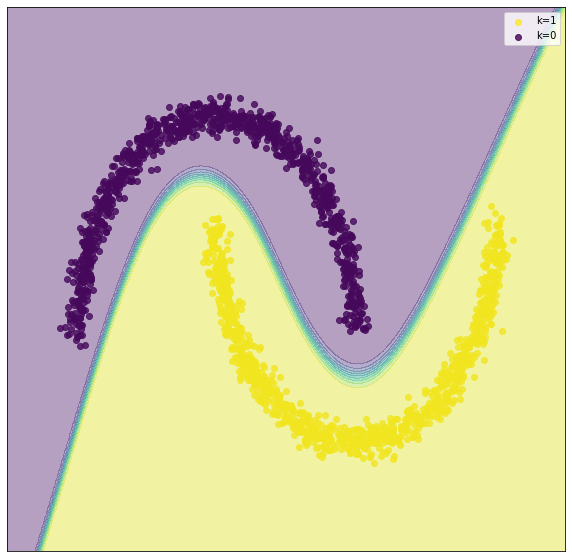

In [5]:
plt.figure(figsize = (10,10))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.scatter(target_samples_1[:,0].numpy(),target_samples_1[:,1].numpy(), color = matplotlib.cm.get_cmap('viridis')(0.999), alpha = 0.8, label = 'k=1')
plt.scatter(target_samples_0[:,0].numpy(),target_samples_0[:,1].numpy(), color = matplotlib.cm.get_cmap('viridis')(0.001), alpha = 0.8, label ='k=0')
plot_2d_function(lambda x: torch.sigmoid(binary_classif.logit_r(x)), x_min = -1.5, x_max = 2.5, y_min = -1, y_max = 1.5, levels = 10, alpha = 0.4, new_figure =False)

In [21]:
from models_nf import MAFLayer, RealNVPDensityEstimatorLayer,MixedModelDensityEstimator
from targets.density_estimation_target import TwoCircles, Moons

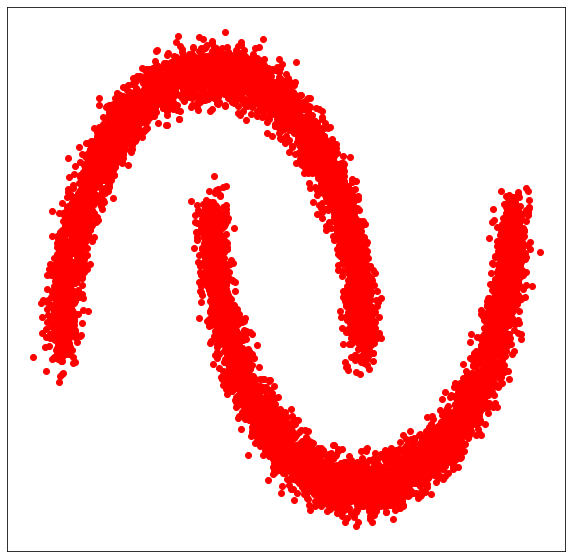

In [22]:
target_samples = Moons().sample(10000)
plt.figure(figsize = (10,10))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.scatter(target_samples[:,0], target_samples[:,1], color = 'red')

In [23]:
structure = [[RealNVPDensityEstimatorLayer, [256,256,256]] for i in range(5)]
NF = MixedModelDensityEstimator(target_samples, structure)
NF.train(500,1000)
NF_samples = NF.sample_model(10000)

figure = plt.figure(figsize = (10,10))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.scatter(NF_samples[:,0], NF_samples[:,1], color = 'blue', alpha = .7)
plot_2d_function(lambda x: torch.exp(NF.log_density(x)), x_min = -1.5, x_max = 2.5, y_min = -1, y_max = 1.5, levels= 100, new_figure = False)

  1%|▋                                                                                                                  | 3/500 [00:05<14:48,  1.79s/it, loss = 119499560.0 ; device: cpu]


KeyboardInterrupt: 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [20:46<00:00,  6.23s/it, loss = 1811.895264]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


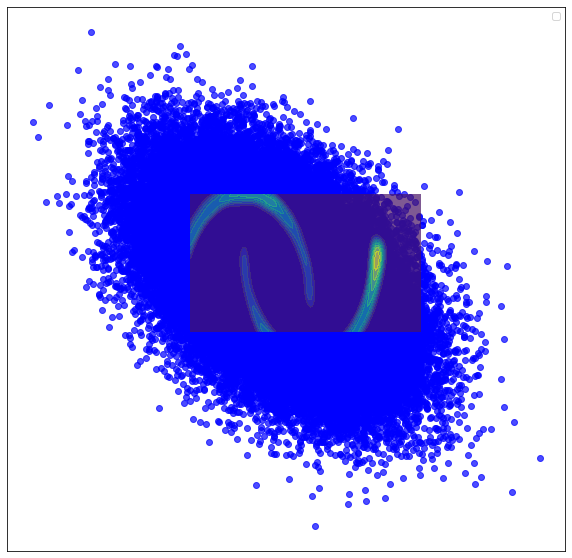

In [33]:
cov = torch.cov(target_samples.T)
NF_samples = torch.distributions.MultivariateNormal(torch.mean(target_samples, dim = 0), 1/2*cov + 1/2*cov.T).sample([100000])
binary_classif = BinaryClassifier(target_samples, NF_samples, [128,128,128])
binary_classif.train(200)

plt.figure(figsize = (10,10))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.scatter(NF_samples[:,0], NF_samples[:,1], color = 'blue', alpha = 0.7)
plot_2d_function(lambda x: torch.sigmoid(binary_classif.logit_r(x)), x_min = -1.5, x_max = 2.5, y_min = -1, y_max = 1.5, levels = 10, new_figure = False)

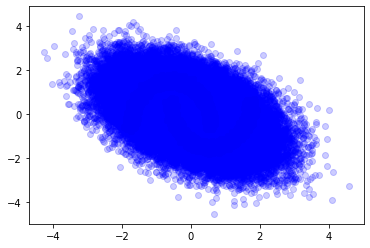

In [34]:
plt.scatter(target_samples[:,0], target_samples[:,1], color = 'red', alpha = 0.2)
plt.scatter(NF_samples[:,0], NF_samples[:,1], color = 'blue', alpha=0.2) 

In [37]:
from torch.distributions import Categorical
def resample_dependant(x):
    ratio = torch.exp(binary_classif.log_density_ratio(x)).squeeze(-1)
    proba = ratio/torch.sum(ratio)
    pick = Categorical(proba).sample([x.shape[0]])
    return(torch.stack([x[pick[i], :] for i in range(x.shape[0])]))

def resample(x):
    U = torch.rand(x.shape[:-1])
    ratio = torch.exp(binary_classif.log_density_ratio(x)).squeeze(-1)
    proba = torch.min(torch.ones_like(U), ratio)
    mask = U<proba
    return x[U<proba]
resampled = NF_samples
for i in range(1):
    resampled = resample(resampled)
print(resampled.shape)

torch.Size([24844, 2])


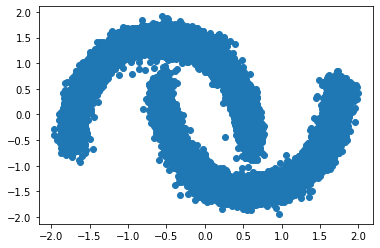

In [38]:
plt.scatter(resampled[:,0],resampled[:,1])